In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib
import seaborn as sns
from itertools import combinations
import pingouin as pg

In [2]:
def new_fig(size, ncols=1, nrows=1, show_spines=True):
    '''
    size - [widthXheight] in cm
    '''
    
    cm = 1/2.54
    f, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(np.array(size)*cm))
    if not show_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    matplotlib.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
    
    return f, ax


def save_fig(filepath):
    
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.savefig(filepath + '.pdf', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filepath + '.jpg', transparent=True, dpi=300, bbox_inches='tight')

# Cortisol vs. mood score correlations

In [3]:
bp_replicates_first = pd.read_excel(
    '../data/bipolar.xlsx',
    sheet_name='data for repeats analysis',
    header=0,
    nrows=6,
    usecols='A:M'
)

bp_replicates_second = pd.read_excel(
    '../data/bipolar.xlsx',
    sheet_name='data for repeats analysis',
    header=7,
    nrows=6,
    usecols='A:M'
)

bp_nonreplicates = pd.read_excel(
    '../data/bipolar.xlsx',
    sheet_name='data for repeats analysis',
    header=15,
    nrows=6
)
############################
# Removing outliers
############################
outliers = ['BP5'] # BP5 - have no mood scores
bp_nonreplicates.drop(columns=outliers, inplace=True)

# uploading the questionnaires scores
# Data of the second measurments
bipolar_mood_scores_second = pd.read_excel('../data/bipolar_mood_scores.xlsx', sheet_name='repeats')
bipolar_mood_scores_second['type'] = 's'
# Data of the first measurments
bipolar_mood_scores_first = pd.read_excel('../data/bipolar_mood_scores.xlsx', sheet_name='Sheet1')
bipolar_mood_scores_first['type'] = 'nr'
bipolar_mood_scores_first.set_index('id', inplace=True)
bipolar_mood_scores_first.loc[bipolar_mood_scores_second['id'], 'type'] = 'f'
bipolar_mood_scores_first.reset_index(inplace=True)


bp_replicates_first.reset_index(inplace=True)
bp_replicates_first.rename(columns={'index': 'segment'}, inplace=True)
bp_replicates_first = bp_replicates_first.pivot_table(columns='segment')
bp_replicates_first.reset_index(inplace=True)
bp_replicates_first.rename(columns={'index': 'id'}, inplace=True)

bp_nonreplicates.reset_index(inplace=True)
bp_nonreplicates.rename(columns={'index': 'segment'}, inplace=True)
bp_nonreplicates = bp_nonreplicates.pivot_table(columns='segment')
bp_nonreplicates.reset_index(inplace=True)
bp_nonreplicates.rename(columns={'index': 'id'}, inplace=True)

bp_first_and_nr = pd.concat((bp_nonreplicates, bp_replicates_first), ignore_index=True)
bp_first_and_nr_merged = pd.merge(bipolar_mood_scores_first, bp_first_and_nr)

bp_replicates_second.reset_index(inplace=True)
bp_replicates_second.rename(columns={'index': 'segment'}, inplace=True)
bp_replicates_second = bp_replicates_second.pivot_table(columns='segment')
bp_replicates_second.reset_index(inplace=True)
bp_replicates_second.rename(columns={'index': 'id'}, inplace=True)

bp_second_merged = pd.merge(bipolar_mood_scores_second, bp_replicates_second)

bp_merged = pd.concat((bp_first_and_nr_merged, bp_second_merged), ignore_index=True)

bp_merged.rename(columns={'HAMA': 'HAM-A'}, inplace=True)

# merge participant information
information = pd.read_excel('../data/Bipolar participant information.xlsx')
bp_merged = bp_merged.merge(information, on='id')

# Participant information statistics

In [4]:
bp_merged['log_cort'] = np.log10(bp_merged[0])
bp_merged['log_cort_std'] = (bp_merged.log_cort - bp_merged.log_cort.mean()) / (bp_merged.log_cort.std())
bp_merged = pd.concat(
    (
        bp_merged,
        pd.get_dummies(bp_merged.gender),
        pd.get_dummies(bp_merged['family status']),
        pd.get_dummies(bp_merged['years of education']),
        pd.get_dummies(bp_merged['under medications']),
    ),
    axis=1
)

In [5]:
fft_participants = ['BP10', 'BP11', 'BP12', 'BP14', 'BP15', 'BP20', 'BP21', 'BP24', 'BP28', 'BP3', \
'BP4', 'BP8', 'BP9', 'BP1', 'BP13', 'BP16', 'BP17', 'BP18', 'BP19', 'BP22', 'BP23', \
'BP25', 'BP26', 'BP29', 'BP31', 'BP33'] + ['BP5', 'BP30']
data = bp_merged.loc[bp_merged['id'].isin(fft_participants)]
data = data[~data.duplicated('id')].copy() # without repeats

N = len(data)
print(f'N={N}')
print()

print('age')
print(f'median={np.median(data.age)}; IQR={np.quantile(data.age, q=0.75)-np.quantile(data.age, q=0.25)}')
print()

field = 'gender'
for field in ['gender', 'family status', 'children', 'years of education', 'under medications', 'Race']:
    print(field)
    for cat in data[field].unique():
        n = np.sum(data[field] == cat)
        print(f'{cat} = {n}; {100*n/N}')
    print()
      
medicated = data[data['under medications'] != 'unmedicated'].copy()
medicated['antidepressants'] = (
    (~pd.isna(medicated['SNRI'])) |
    (~pd.isna(medicated['SSRI'])) |
    (~pd.isna(medicated['atypical antideprrasant']))
)
print('mood stabilizer')
print(medicated['mood stabilizer'].count(), medicated['mood stabilizer'].count()/len(medicated))
print('anti-psychotic')
print(medicated['anti-psychotic'].count(), medicated['anti-psychotic'].count()/len(medicated))
print('antidepressants')
print(np.sum(medicated['antidepressants']), np.sum(medicated['antidepressants'])/len(medicated))

N=26

age
median=32.0; IQR=13.375

gender
F = 21; 80.76923076923077
M = 5; 19.23076923076923

family status
single = 18; 69.23076923076923
divorced = 5; 19.23076923076923
maried = 3; 11.538461538461538

children
0.0 = 14; 53.84615384615385
1.0 = 5; 19.23076923076923
2.0 = 4; 15.384615384615385
nan = 0; 0.0

years of education
more than 12 = 21; 80.76923076923077
9 to 12 = 5; 19.23076923076923

under medications
irregular = 2; 7.6923076923076925
unmedicated = 10; 38.46153846153846
medicated = 14; 53.84615384615385

Race
White = 23; 88.46153846153847
Asian = 1; 3.8461538461538463
Unknown or not reported = 1; 3.8461538461538463
African = 1; 3.8461538461538463

mood stabilizer
15 0.9375
anti-psychotic
10 0.625
antidepressants
10 0.625


# partial correlations

In [7]:
# wo BP30 which had very high mean raw cortisol level (> 3 stds from the mean raw cortisol)
bp_wo_bp30 = bp_merged.set_index('id').drop(index='BP30').reset_index()
for question in ['BDI', 'HDRS', 'HAM-A', 'YMRS']:
    print(f'{question} vs. log(cortisol):')
    print(pg.partial_corr(
        data=bp_wo_bp30,
        x='log_cort',
        y=question,
        covar=['age', 'F', 'M', 'divorced', 'maried', 'single', '9 to 12', 'more than 12', 'irregular', 'medicated', 'unmedicated'],
        alternative='greater',
    ).round(3))
    N_females = np.sum(np.isfinite(bp_wo_bp30[question]) & (bp_wo_bp30.gender == 'F'))
    print(f'{N_females}/{np.sum(np.isfinite(bp_wo_bp30[question]))} are females')
    print()

BDI vs. log(cortisol):
          n      r        CI95%  p-val
pearson  37  0.467  [0.16, 1.0]  0.008
31/37 are females

HDRS vs. log(cortisol):
          n      r        CI95%  p-val
pearson  38  0.548  [0.27, 1.0]  0.002
32/38 are females

HAM-A vs. log(cortisol):
          n     r        CI95%  p-val
pearson  38  0.47  [0.17, 1.0]  0.007
32/38 are females

YMRS vs. log(cortisol):
          n      r         CI95%  p-val
pearson  36  0.232  [-0.11, 1.0]  0.132
30/36 are females



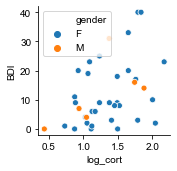

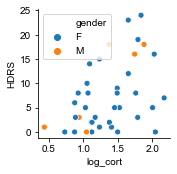

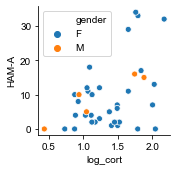

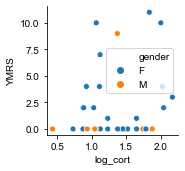

In [8]:
for question in ['BDI', 'HDRS','HAM-A', 'YMRS']:
    f, ax = new_fig((6, 6), show_spines=False)
    sns.scatterplot(x='log_cort', y=question, hue='gender', data=bp_wo_bp30)
    plt.show()

In [9]:
# without the 13 repeated measurments
wo_bp30_wo_repeats = bp_wo_bp30[bp_wo_bp30['type'] != 's']
for question in ['BDI', 'HDRS', 'HAM-A', 'YMRS']:
    print(f'{question} vs. log(cortisol):')
    print(pg.partial_corr(
        data=wo_bp30_wo_repeats,
        x='log_cort',
        y=question,
        covar=['age', 'F', 'M', 'divorced', 'maried', 'single', '9 to 12', 'more than 12', 'irregular', 'medicated', 'unmedicated'],
        alternative='greater',
    ).round(3))
    N_females = np.sum(np.isfinite(wo_bp30_wo_repeats[question]) & (wo_bp30_wo_repeats.gender == 'F'))
    print(f'{N_females}/{np.sum(np.isfinite(wo_bp30_wo_repeats[question]))} are females')
    print()

BDI vs. log(cortisol):
          n      r         CI95%  p-val
pearson  25  0.343  [-0.14, 1.0]  0.115
21/25 are females

HDRS vs. log(cortisol):
          n      r        CI95%  p-val
pearson  25  0.492  [0.04, 1.0]  0.037
21/25 are females

HAM-A vs. log(cortisol):
          n      r         CI95%  p-val
pearson  25  0.299  [-0.19, 1.0]   0.15
21/25 are females

YMRS vs. log(cortisol):
          n      r         CI95%  p-val
pearson  23  0.259  [-0.28, 1.0]  0.208
19/23 are females



## Score correlations

N=37
BDI vs. HDRS pearson: r=0.88, p=5.832261029210593e-13



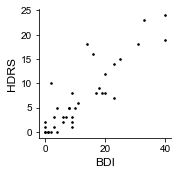

N=37
BDI vs. HAM-A pearson: r=0.72, p=4.738349712163454e-07



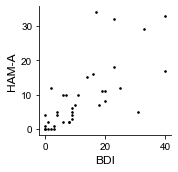

N=38
HDRS vs. HAM-A pearson: r=0.66, p=6.955624086469542e-06



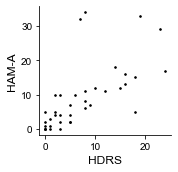

In [10]:
questions = ['BDI', 'HDRS','HAM-A']
for comb in combinations(questions, 2):
    idx = (np.isfinite(bp_wo_bp30[comb[0]])) & (np.isfinite(bp_wo_bp30[comb[1]]))
    
    f, ax = new_fig((6, 6), show_spines=False)
    plt.scatter(x=bp_wo_bp30[comb[0]][idx], y=bp_wo_bp30[comb[1]][idx], color='black', s=2.5)
    plt.xlabel(comb[0], size=12)
    plt.xticks(fontsize=10)
    plt.ylabel(comb[1], size=12)
    plt.yticks(fontsize=10)
    
    print(f'N={sum(idx)}')
    r, p = st.pearsonr(bp_wo_bp30[comb[0]][idx], bp_wo_bp30[comb[1]][idx])
    print(f'{comb[0]} vs. {comb[1]} pearson: r={r:0.2f}, p={p}')
    print()

    plt.show()